In [6]:
import sys, itertools
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import sklearn, time, math
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import confusion_matrix

if '../tools' not in sys.path:
    sys.path.append('../tools')
from helper_functions import * 

import warnings
warnings.filterwarnings('ignore')

In [9]:
def log_range(lo, hi): return [10 ** i for i in range(lo, hi)]
    
def best(scores, hypers):
    best = max(scores)
    return best, hypers[scores.index(best)]

def run(X, Y, hypers, classifier, data_change=None):
    hypers = list(hypers)
    best_acc, best_params = -np.inf, None
    skf = StratifiedKFold(Y, n_folds=8, shuffle=True, random_state=1)
    scores = []
    nproc = 8
    for i, h in enumerate(hypers):
        svm = classifier(h)
        mX = X
        if data_change: mX = data_change(mX, h)
        c = np.average(cross_val_score(svm, mX, Y, cv=skf, n_jobs=-1))
        scores.append(c)
        print('\r{} best acc {} params {}'.format(
                completion_bar(len(scores), len(hypers), width=20),
                *best(scores, hypers)), end='')
        sys.stdout.flush()
    print()
    return best(scores, hypers)


In [107]:
df = ['ovo', 'ovr']
Cs = log_range(-5, 5)
kernels = ['rbf', 'poly']
def make_svm(tup):
    C, k, d = tup
    if k == 'poly': return SVC(C=C, kernel=k, decision_function_shape=d, degree=10., coef0=1.)
    return SVC(C=C, kernel=k, decision_function_shape=d)

M, Y = load_all_fv(3, 3)
C, Y = load_chroma_fv(3, 3)

top_mfcc_svm, top_chroma_svm = None, None

print('mfcc(3,3) on SVM (hyper is C, kernel, ovo/ovr)')
top_mfcc_svm = run(M, Y, itertools.product(Cs, kernels, df), make_svm)

loss = ['hinge', 'squared_hinge']
def make_lsvm(tup):
    C, l = tup
    return LinearSVC(C=C, loss=l)
print('mfcc(3,3) on LinearSVM (hyper is C, kernel, ovo/ovr)')
x = run(M, Y, itertools.product(Cs, loss), make_lsvm)
if x[0] > top_mfcc_svm[0]: top_mfcc_svm = make_lsvm(x[1])
else: top_mfcc_svm = make_svm(top_mfcc_svm[1])

print('chroma(3,3) on SVM (hyper is C, kernel, ovo/ovr)')
top_chroma_svm = run(C, Y, itertools.product(Cs, kernels, df), make_svm)

print('chroma(3,3) on LinearSVM (hyper is C, kernel)')
x = run(C, Y, itertools.product(Cs, loss), make_lsvm)
if x[0] > top_chroma_svm[0]: top_chroma_svm = make_lsvm(x[1])
else: top_chroma_svm = make_svm(top_chroma_svm[1])

Using existing FVs from file ../generated-fv/FV3-3.mat
N = 1000
MFCC training feature ranges means [-0.0201, 0.0090] sds [0.0202, 0.0614]
Using existing FVs from file ../generated-fv/FVC3-3.mat
N = 1000
chroma training feature ranges means [-0.0107, 0.0108] sds [0.0376, 0.0670]
mfcc(3,3) on SVM (hyper is C, kernel, ovo/ovr)
[--------------------] 40/40 best acc 0.6744391025641026 params (100, 'poly', 'ovo')
mfcc(3,3) on LinearSVM (hyper is C, kernel, ovo/ovr)
[--------------------] 20/20 best acc 0.6481570512820513 params (1, 'squared_hinge')
chroma(3,3) on SVM (hyper is C, kernel, ovo/ovr)
[--------------------] 40/40 best acc 0.47508012820512824 params (1000, 'poly', 'ovo')
chroma(3,3) on LinearSVM (hyper is C, kernel)
[--------------------] 20/20 best acc 0.47187500000000004 params (10, 'squared_hinge')


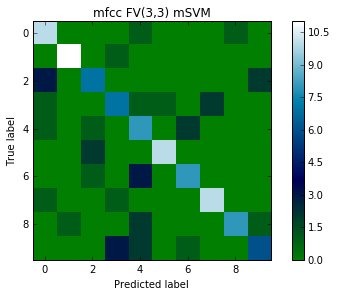

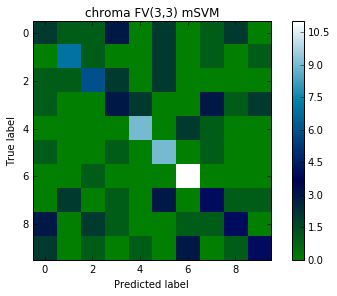

In [10]:
trM, teM, trC, teC, trY, teY = train_test_split(M, C, Y, stratify=Y,
                                      random_state=1, test_size=(1/8))
top_mfcc_svm.fit(trM, trY)
plot_confusion_matrix(confusion_matrix(teY, top_mfcc_svm.predict(teM)),
                      title='mfcc FV(3,3) mSVM')
plt.show()
top_mfcc_svm.fit(trC, trY)
plot_confusion_matrix(confusion_matrix(teY, top_mfcc_svm.predict(teC)),
                      title='chroma FV(3,3) mSVM')
plt.show()

In [17]:
df = ['ovo', 'ovr']
Cs = log_range(0, 7)
kernels = ['rbf', 'poly']
print('mfcc(3,3)+chroma(3,3) on SVM (hyper is C, k, df)')
svm33 = make_svm(run(X, Y, itertools.product(Cs, kernels, df), make_svm)[1])

mfcc(3,3)+chroma(3,3) on SVM (hyper is C, k)
[--------------------] 28/28 best acc 0.6842147435897437 params (100, 'poly', 'ovo')


In [19]:
M, Y = load_all_fv(8, 8)
C, Y = load_chroma_fv(8, 8)
X = np.concatenate((M, C), axis=1)
print('mfcc(8,8) on SVM (hyper is C, k, df)')
run(M, Y, itertools.product(Cs, kernels, df), make_svm)
print('chroma(8,8) on SVM (hyper is C, k, df)')
run(C, Y, itertools.product(Cs, kernels, df), make_svm)
print('mfcc(8,8)+chroma(8,8) on SVM (hyper is C, k, df)')
run(X, Y, itertools.product(Cs, kernels, df), make_svm)

Using existing FVs from file ../generated-fv/FV8-8.mat
N = 1000
MFCC training feature ranges means [-0.0057, 0.0032] sds [0.0072, 0.0278]
Using existing FVs from file ../generated-fv/FVC8-8.mat
N = 1000
chroma training feature ranges means [-0.0052, 0.0048] sds [0.0105, 0.0292]
mfcc(8,8) on SVM (hyper is C, k, df)
[--------------------] 28/28 best acc 0.6828525641025641 params (10000, 'rbf', 'ovo')
chroma(8,8) on SVM (hyper is C, k, df)
[--------------------] 28/28 best acc 0.5167467948717948 params (1000, 'poly', 'ovo')
mfcc(8,8)+chroma(8,8) on SVM (hyper is C, k, df)
[--------------------] 28/28 best acc 0.7090544871794872 params (1000, 'poly', 'ovo')


(0.70905448717948716, (1000, 'poly', 'ovo'))

In [20]:
X.shape

(1000, 9152)

In [ ]:
import multiprocessing
def make_svm(C):
    return SVC(C=C, kernel='poly',
               decision_function_shape='ovo',
               degree=10., coef0=1.)
Cs = log_range(0, 15)
def rf(): return RandomForestClassifier(n_estimators=200, max_depth=20)
def rfit(tup):
    trX, teX, trY, teY = tup
    #trX, teX = whiten(trX), whiten(teX, source=trX) <- lowers accuracy for some reason
    return order(rf().fit(trX, trY).feature_importances_), trX, teX, trY, teY
def cvFolds(X, Y):
    skf = StratifiedKFold(Y, n_folds=8, shuffle=True,
                          random_state=1)
    sets = [(X[train], X[test], Y[train], Y[test]) for train, test in skf]
    with multiprocessing.Pool(8) as p:
        return p.map(rfit, sets)

def eval_fold(tup):
    (prop, C), (p, trX, teX, trY, teY) = tup
    svm = make_svm(C)
    p = p[:int(len(p) * prop)]
    trXp, teXp = trX[:, p], teX[:, p]
    return svm.fit(trXp, trY).score(teXp, teY)
    
def run_rf(folds, prop):
    best_acc, best_params = -np.inf, None
    for i, C in enumerate(Cs, 1):
        with multiprocessing.Pool(8) as p:
            scores = p.map(eval_fold, zip(itertools.repeat((prop, C)), folds))
        score = np.average(scores)
        if score > best_acc:
            best_acc = score
            best_params = C
        print('\r{} best acc {} params {}'.format(
                completion_bar(i, len(Cs), width=20),
                best_acc, best_params), end='')
        sys.stdout.flush()
    print()
    return best_acc, best_params

In [40]:
cv = cvFolds(X, Y)

In [44]:
run_rf(cv, 0.5)

[--------------------] 10/10 best acc 0.7052884615384616 params 1000000000


(0.70528846153846159, 1000000000)

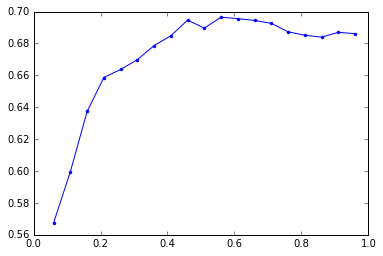

In [64]:
# Output from running run_rf on FV(3,3) on cycles in parallel 
l = [0.11, 0.599679487179,
0.16, 0.637419871795,
0.21, 0.658653846154,
0.26, 0.663701923077,
0.06, 0.567628205128,
0.36, 0.678685897436,
0.31, 0.669871794872,
0.41, 0.684855769231,
0.46, 0.694631410256,
0.51, 0.689663461538,
0.56, 0.696474358974,
0.61, 0.695592948718,
0.66, 0.694471153846,
0.71, 0.692628205128,
0.76, 0.68733974359,
0.81, 0.685176282051,
0.86, 0.683974358974,
0.91, 0.687019230769,
0.96, 0.686137820513]
x, y = zip(*sorted(zip(l[0:len(l):2], l[1:len(l):2])))
plt.plot(x, y, '.-')
plt.show()

In [56]:
def to_try(x): return [(8,3)] + list((x, x) for x in range(3, 12)) + list((x, 11) for x in range(3, x))
l = list(itertools.product(to_try(21), to_try(31)))
assert(len(l) % 4 == 0)
l = list(chunks(l, len(l) // 4))[0]
def try_config(params):
    print('starting', params)
    mfcc, chroma = params
    M, Y = load_all_fv(*mfcc)
    C, Y = load_chroma_fv(*chroma)
    X = np.concatenate((M, C), axis=1)
    cv = cvFolds(X, Y)
    run_rf(cv, 0.5)
    print('finished', params, 'acc', 'C')
# should be run on cycles
with multiprocessing.Pool(48) as p:
    p.map(try_config, l)

starting ((8, 3), (8, 3))
starting ((8, 3), (4, 4))
starting ((8, 3), (5, 11))
starting ((8, 3), (9, 11))
starting ((8, 3), (11, 11))
starting ((8, 3), (7, 11))
starting ((8, 3), (6, 6))
starting ((8, 3), (13, 11))
starting ((3, 3), (6, 6))
starting ((4, 4), (3, 11))
starting ((4, 4), (7, 11))
starting ((3, 3), (17, 11))
starting ((4, 4), (8, 3))
starting ((8, 3), (21, 11))
starting ((3, 3), (27, 11))
starting ((4, 4), (9, 11))
starting ((3, 3), (10, 10))
starting ((3, 3), (11, 11))
starting ((8, 3), (8, 8))
starting ((8, 3), (15, 11))
starting ((8, 3), (27, 11))
starting ((8, 3), (23, 11))
starting ((8, 3), (29, 11))
starting ((3, 3), (8, 3))
starting ((3, 3), (13, 11))
starting ((3, 3), (5, 11))
starting ((3, 3), (7, 11))
starting ((3, 3), (21, 11))
starting ((4, 4), (4, 4))
starting ((4, 4), (10, 10))
starting ((4, 4), (8, 8))
starting ((4, 4), (29, 11))
starting ((4, 4), (25, 11))
starting ((4, 4), (23, 11))
starting ((4, 4), (27, 11))
starting ((5, 5), (8, 3))
starting ((5, 5), (4

In [ ]:
# Stanford mSVM http://nlp.stanford.edu/IR-book/html/htmledition/multiclass-svms-1.html
# This requires a new convex program formulation, unsupported within-python.
# Below

In [ ]:
class DummyPredictor:
    def __init__(self, res):
        self._res = res
    def predict(self, X):
        Y = np.empty([len(X), 1])
        Y.fill(self._res)
        return Y
        
def find_best(subsets, X, origY, C):
    best_accuracy, best_classifier, best_set = -np.inf, None, None
    val = int(0.8 * len(X))
    for subset in subsets:
        Y = np.array([y in subset for y in origY])
        svm = SVC(C=C).fit(X[:val], Y[:val])
        acc = svm.score(X[val:], Y[val:])
        if acc > best_accuracy:
            best_accuracy = acc
            best_classifier = svm
            best_set = subset
    return best_accuracy, best_classifier, best_set
    
def best_subset_finder(labels, C=1.0):
    assert len(labels) > 0
    if len(labels) == 1:
        return {}, DummyPredictor(next(iter(labels))), {}
    if len(labels) == 2:
        return {}, SVC(C=C).fit(trXadj, trY), {}
    
    subsets = []
    for i in range(1, len(labels) // 2 + 1):
        for subset in itertools.combinations(labels, i):
            subsets.append(subset)
    p = np.random.permutation(len(trXadj))
    pX = trXadj[p]
    pY = trY[p]
    
    nproc = 4
    print('  Launching {} parallel tasks for {} problems.'.format(nproc, len(subsets)))
    sys.stdout.flush()
    np.random.shuffle(subsets)
    
    best_parallel = Parallel(n_jobs=2, backend='threading') \
        (delayed(find_best)(i, pX, pY, C) for i in chunks(subsets, max(len(subsets) // nproc, 1)))
    best_accuracy, best_set, best_classifier = -np.inf, None, None
    for job_best_acc, job_best_classifier, job_best_set in best_parallel:
         if job_best_acc > best_accuracy:
             best_accuracy = job_best_acc
             best_classifier = job_best_classifier
             best_set = set(job_best_set)
         
    other = labels - best_set
    print('  Split on 0/1 for {} vs {}, validation acc {}'.format(
        best_set, other, best_accuracy))
    sys.stdout.flush()
    assert best_classifier
    return best_set, best_classifier, other

class DTree(object):
    def __init__(self, classifier, lset, rset):
        self.lset = lset
        self.rset = rset
        self.left = None
        self.right = None
        self.classifier = classifier

def binary_dtree(labels, C=10.0, debug_print_level=None):
    dbp = debug_print_level
    if dbp: print('Level {}'.format(dbp))
    left, svm, right = best_subset_finder(labels)
    if not left: assert not right
    x = DTree(svm, left, right)
    if not left: return x
    x.left = binary_dtree(left, C=(C * len(left) / len(labels)),
                          debug_print_level=(dbp + '0' if dbp else None))
    x.right = binary_dtree(right, C=(C * len(right) / len(labels)),
                           debug_print_level=(dbp + '1' if dbp else None))
    return x

In [ ]:
bdt = binary_dtree(set(trY), C=10.0, debug_print_level='r')

In [ ]:
#What if we retrain on the whole training dataset?
def dtree_predict(dt, x):
    y = dt.classifier.predict([x])[0]
    if not dt.left: return y
    subtree = dt.left if y else dt.right
    return dtree_predict(subtree, x)

def vec_dtree_predict(dt, X):
    return np.array([dtree_predict(dt, x) for x in X])

np.sum(vec_dtree_predict(bdt, teXadj) == teY) / len(teY)